# Bayesian Hierarchical Modeling

A hands-on introduction to BHMs by looking at PyMC and Supernova Cosmology

## Problem to be solved

We want to do Bayesian Statistics (estimate model parameter PDFs given some data) but our data has some intrinsic grouping. For SN cosmology, this is often "a survey", but it can be other data set features as well. Therfore, this is no longer a straight forward linear regression for two main reasons. 

1. Independence of samples is an important assumption for many statistical tests, like maximum likelihood estimation.
1. We may want to capture the variation of the model parmeters across sub-groups.

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="talk", style="ticks", font="serif", color_codes=True)

np.random.seed(0)

## Exploring a Simple Hierarchical Model

### Model Amnesia

Here is an example of why you might want a bit of memory in your models.

>[T]he waiting time to get a cheeseburger at The Tavern to the Golden M in Germany takes two minutes on average (I made up this number). If I go to France now, chances are that the average waiting time is not too far off from these two minutes. And probably the same goes for Japan. Sure, some countries are faster, and some are slower on average, but waiting for a cheeseburger for an hour should be a somewhat rare exception, regardless of the country. So, if I am hungry and want a cheeseburger in France, I have an expectation of how long I have to wait, and I will probably be kind of right. I can transfer knowledge learned from one group (Germany) to make predictions for another group (France).

Dr. Robert Kübler, "Bayesian Hierarchical Modeling in PyMC3"

Three options to predict how long it will take to make a cheeseburger.
1. Maybe this should just be one model that marginalizes over the country (fully pooled).
1. Germany, France, and Japan can all be different models with no relationship across countries (unpooled).
1. Finally, you can fit for both the per-country cheeseburger rate, along with the planetary average that influences the priors of the per-country rate (BHM).

### Building a mock dataset

Let's make a data set of 8 sub-sets. This is a 1D model fit: one x (feature) and one y (target). The truth values in this data set are that there are 8 individual slopes, one per subgroup, and all have a fixed intercept of zero.

In [2]:
mean_slope = 2 
# the 8 different slopes have a mean of 2 and sigma of 1
slopes = np.random.normal(mean_slope, size=8)

# group "7" is smaller than all other groups.
groups = np.array(50*[0, 1, 2, 3, 4, 5, 6] + 5*[7])

x_obs = np.random.randn(355)
# y_obs has noise at the level of 0.1 compared to the "true" value of `slopes[groups] * x`
y_obs = slopes[groups] * x_obs + 0.1*np.random.randn(355)

In [3]:
# Lets look at our slopes, since 8 is a small sample set.
print(slopes)
print(np.mean(slopes))

[3.76405235 2.40015721 2.97873798 4.2408932  3.86755799 1.02272212
 2.95008842 1.84864279]
2.884106507142941


In [4]:
# all of group 2 can be found via
print(f'{x_obs[groups==2]=}')
print(f'{y_obs[groups==2]=}')
print(f'{slopes[2]=}')

x_obs[groups==2]=array([ 0.14404357, -0.20515826,  2.26975462,  0.37816252, -0.38732682,
       -0.4380743 , -0.51080514, -0.36274117, -1.63019835, -1.23482582,
       -1.16514984, -0.17992484,  0.3563664 , -1.34775906,  1.92294203,
        0.8024564 ,  0.29823817,  0.40746184,  0.57659082,  0.63503144,
       -0.06824161, -1.07993151, -1.22543552,  0.31872765, -0.4555325 ,
       -1.60205766, -0.03928282,  1.33652795, -0.02432612, -0.4664191 ,
       -0.955945  ,  0.23218104, -1.15618243, -0.39727181, -0.81336426,
        0.69474914, -0.59631404,  0.09740017,  0.49374178,  1.53637705,
       -0.62808756,  0.58295368,  0.66638308,  1.07774381, -0.0616264 ,
       -0.31229225,  0.77325298,  1.6595508 , -0.36469354, -0.68944918])
y_obs[groups==2]=array([ 0.44516087, -0.52694959,  6.8490222 ,  1.02789599, -1.31539252,
       -1.36477396, -1.51566211, -0.90723877, -4.79771128, -3.73515378,
       -3.43919437, -0.54454202,  1.05048319, -4.06150753,  5.7460743 ,
        2.18866668,  0.800131

Now we will add two outliers the small "group 7".

In [5]:
y_obs[-1] = 30
y_obs[-2] = 20

<Axes: >

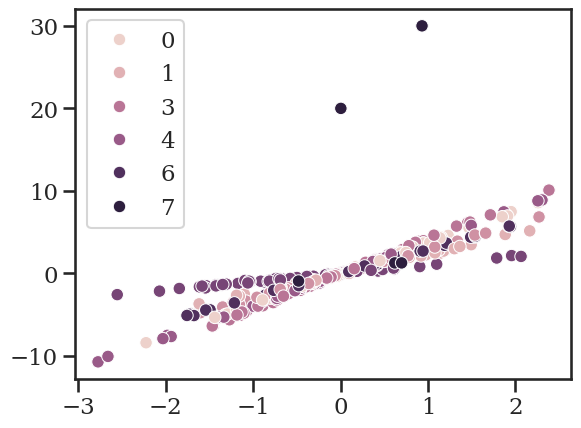

In [6]:
plt.figure()
sns.scatterplot(x=x_obs, y=y_obs, hue=groups)

### Fitting Slopes With a Pooled Model

Along with an introduciton to `pymc3`.

In [7]:
# model is y = m*x + noise

# build a model via a `with` context block.
with pm.Model() as pooled_model:
    # define priors on single slope and the added noise
    slope = pm.Normal('slope', 0, 20)
    noise = pm.Exponential('noise', 0.1)

    # define observations: y_obs = slope * x_obs + noise.
    # link variables to data with `observed=y`
    obs = pm.Normal('obs', slope*x_obs, noise, observed=y_obs)

    # run sampler
    pooled_trace = pm.sample()#return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


<Axes: title={'center': 'slope'}>

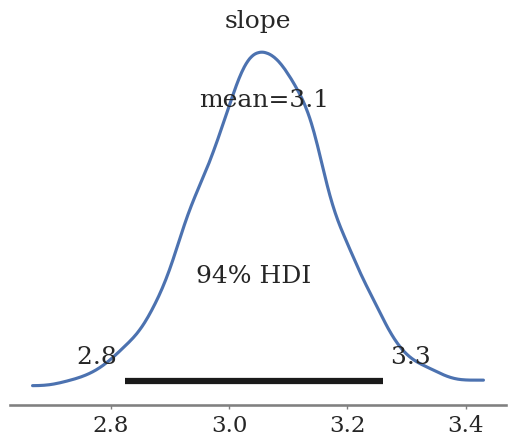

In [8]:
az.plot_posterior(pooled_trace, var_names=['slope'])

The slope here is $3.1 \pm 0.2$. This is not exactly 2.9.

### Fitting Slopes With an Unpooled Model

This is eight different slopes that have no knowledge of each other.

In [9]:
with pm.Model() as unpooled_model:
    slope = pm.Normal('slope', 0, 20, shape=8)
    noise = pm.Exponential('noise', 10)
    
    obs = pm.Normal('obs', slope[groups]*x_obs, noise, observed=y_obs)
    
    unpooled_trace = pm.sample(return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

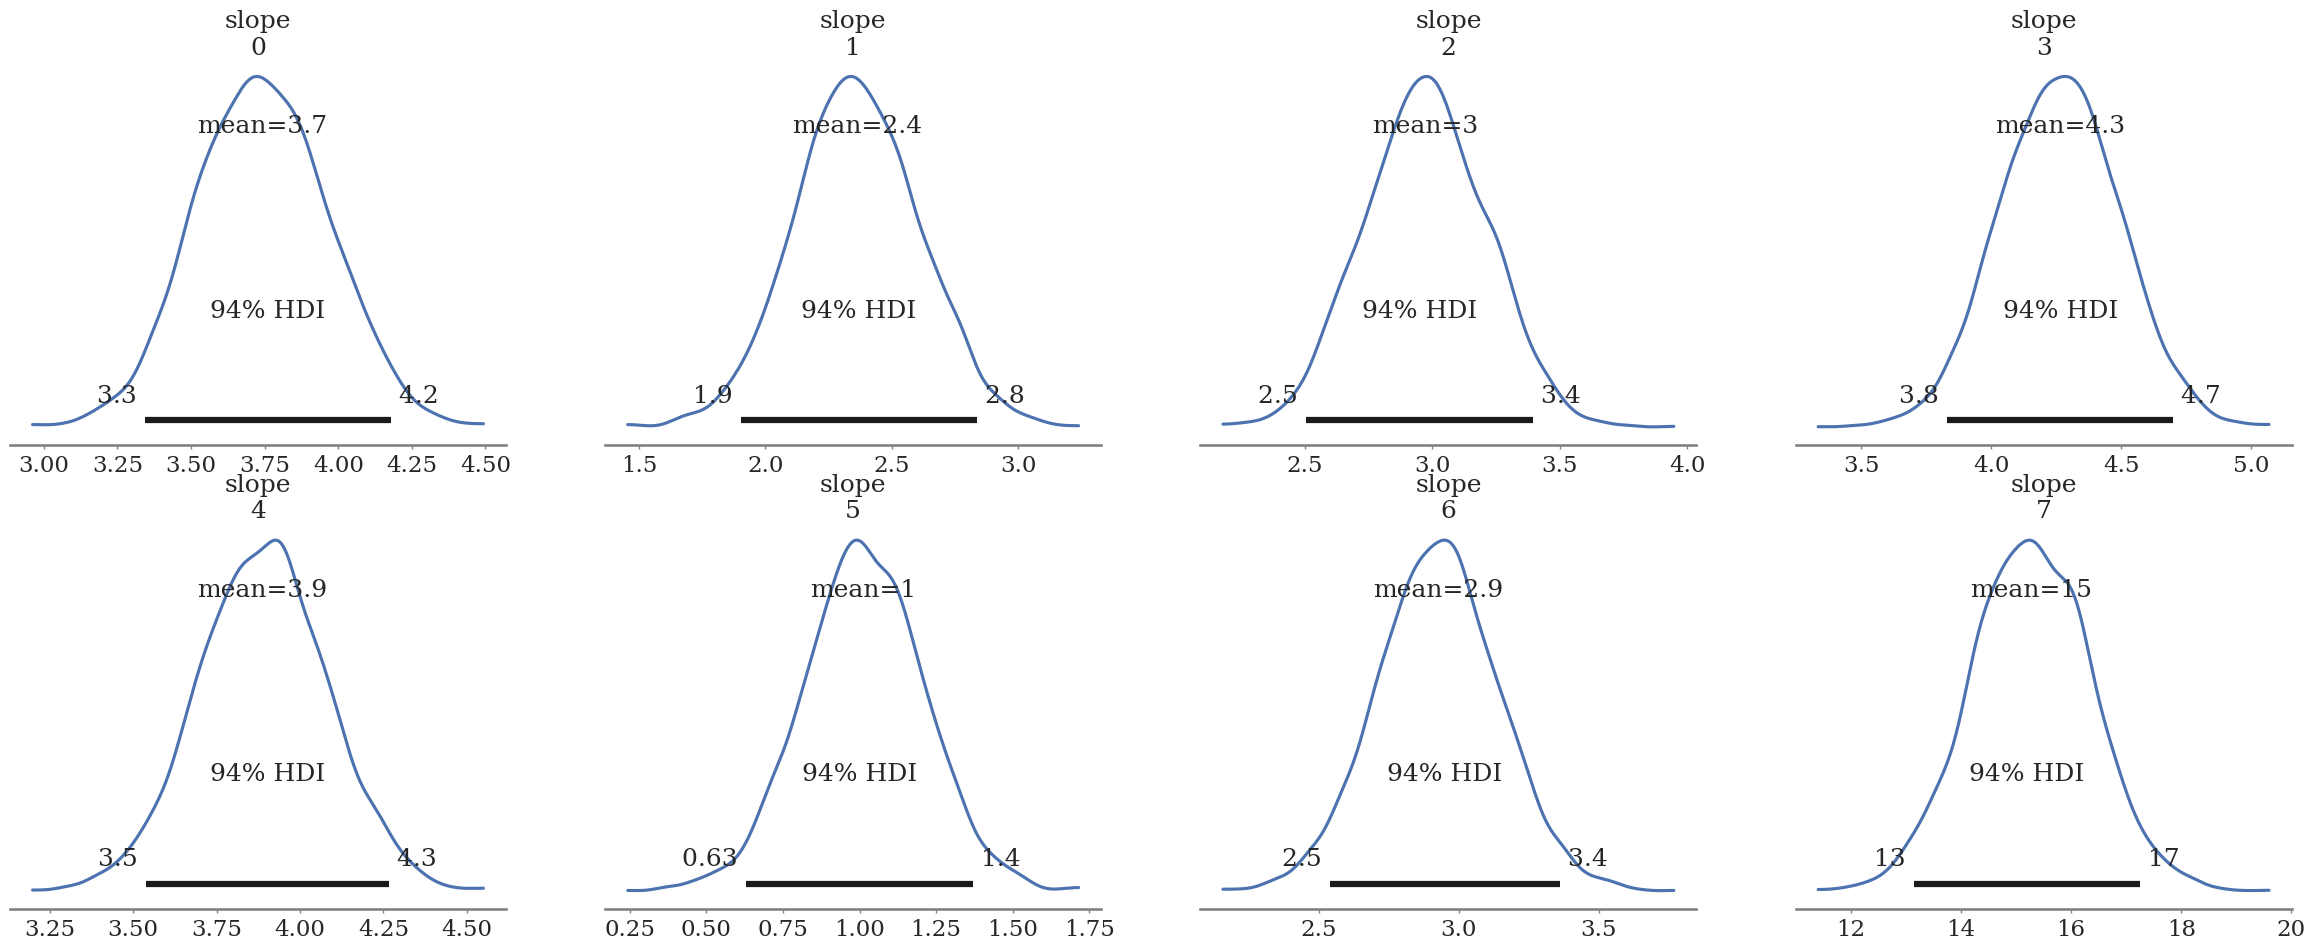

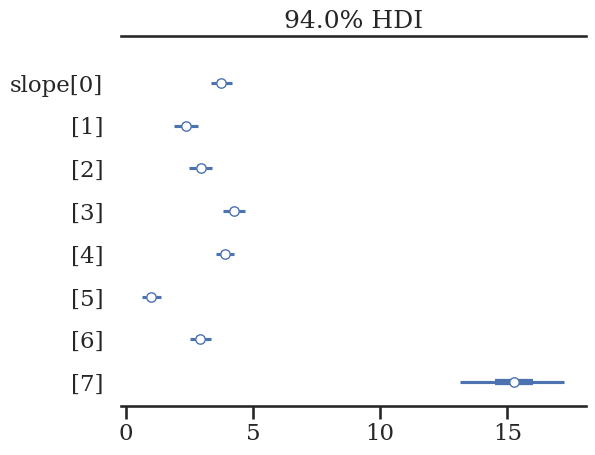

In [10]:
az.plot_posterior(unpooled_trace, var_names=['slope'])
az.plot_forest(unpooled_trace, var_names=['slope'], combined=True)

**Group 7 should be 1.8!** Let's use the other subgroups to improve our estimate of the true value for "group 7".

> In hierarchical modeling, all parameters are being pulled towards a global mean. This effect is known as shrinkage.

Dr. Robert Kübler, "Bayesian Hierarchical Modeling in PyMC3"

### Example of a BHM

> We want to find a middle ground that finds a compromise between these extremes — partial pooling. This brings us to Bayesian hierarchical modeling, also known as multilevel modeling.

Surya Krishnamurthy, "Introduction to hierarchical modeling"

In [11]:
with pm.Model() as hierarchical_model:
    # now you need "hyperpriors" to provide information to transfer between sub-models
    # mu_slope is the global average
    # simga_slope is the strength of the information transfer
    # sigma_slope = 0 is pooled. simga_slope = inf is unpooled. BHM is in the middle.
    mu_slope = pm.Normal('mu_slope', 0, 1) # hyperprior 1
    sigma_slope = pm.Exponential('sigma_slope', 13) # hyperprior 2

    # Same "priors" as `unpooled_model` 
    #but now `mu_slope` and `sigma_slope` are variables and not values
    slope = pm.Normal('slope', mu_slope, sigma_slope, shape=8)
    noise = pm.Exponential('noise', 10)
    
    obs = pm.Normal('obs', slope[groups]*x_obs, noise, observed=y_obs)

    # Note that we ended up adjusting how the sampler worked (`target_accept=0.995`)
    # This model has the most parameters (and correlations), so it can become hard to converve
    hierarchical_trace = pm.sample(
        return_inferencedata=True,
        target_accept=0.995
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_slope, sigma_slope, slope, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

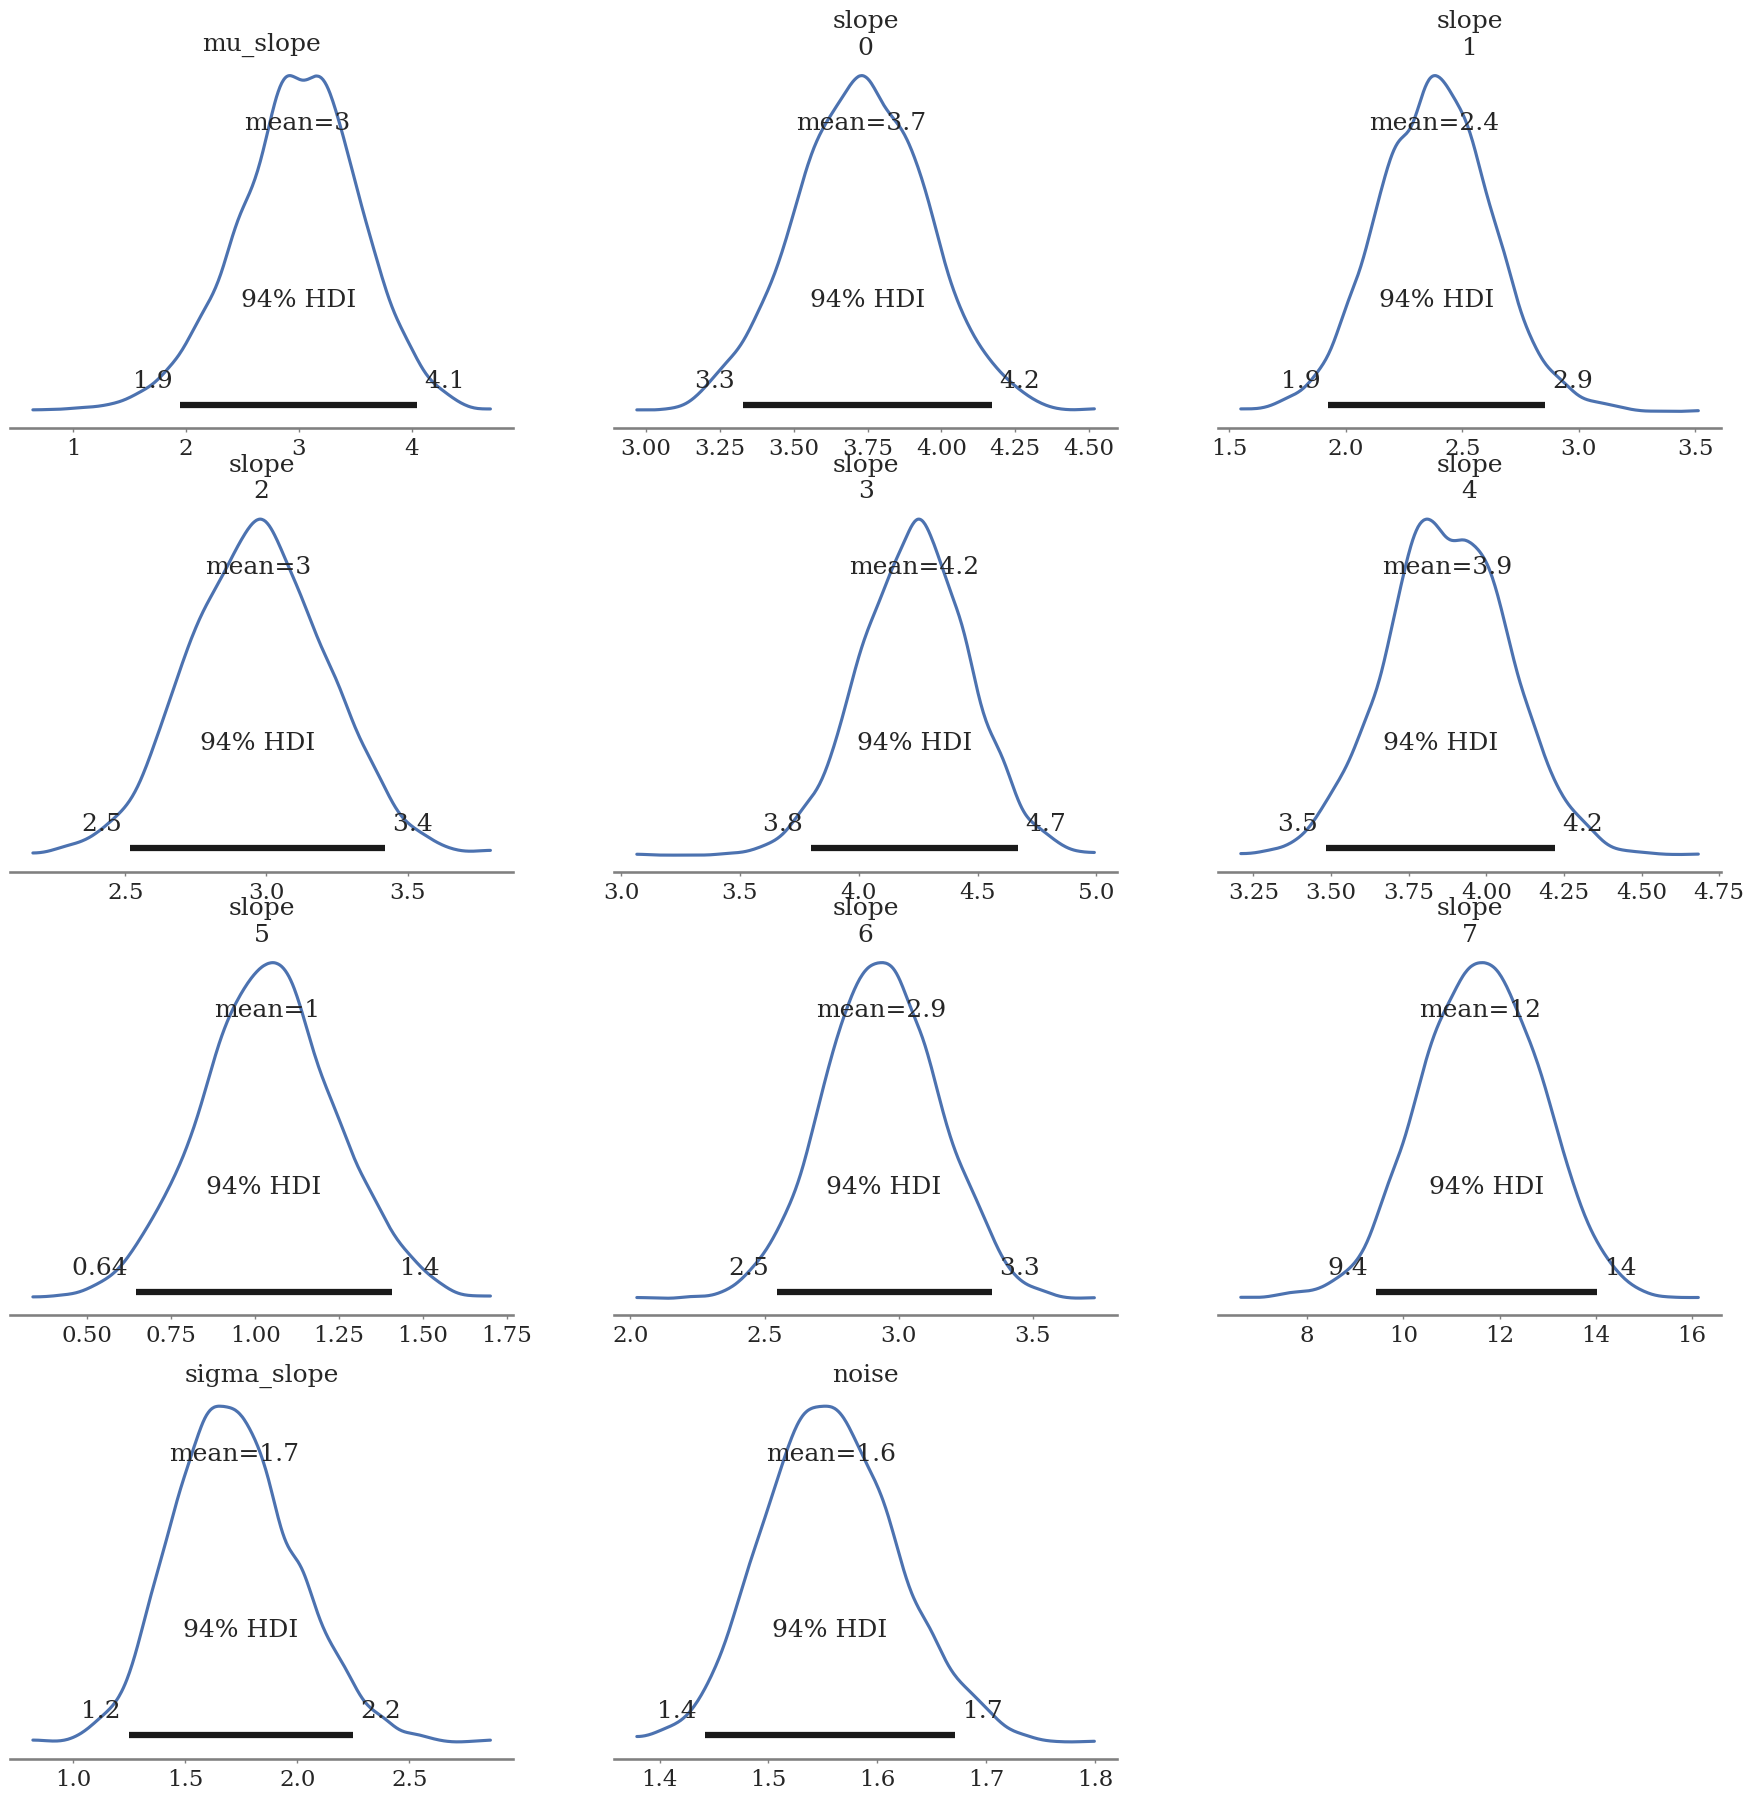

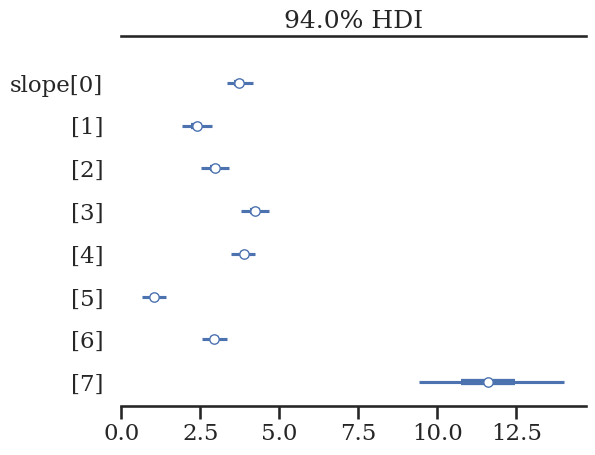

In [12]:
az.plot_posterior(hierarchical_trace)
az.plot_forest(hierarchical_trace, var_names=['slope'], combined=True)

Group 7 is still dominated by the 40% outliers, but this is much closer to the true values that were used to build the dataset.

## Visually Describing Models

"Plate notation" is a method of representing variables, their relationships, and how they repeat (think vector vs matrix vs scalar) in a graphical form. We typically use a tool and standard called [Graphviz](https://www.graphviz.org) to do this.

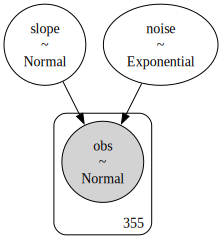

In [13]:
pm.model_to_graphviz(pooled_model)

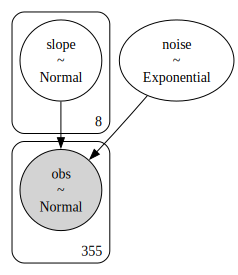

In [14]:
pm.model_to_graphviz(unpooled_model)

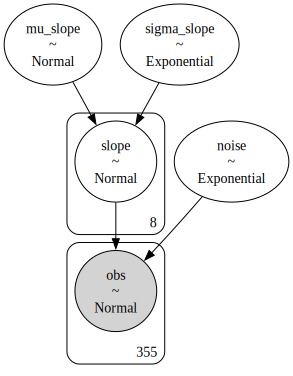

In [15]:
pm.model_to_graphviz(hierarchical_model)

## BHMs in SN Cosmology

There are two common BHMs in SN cosmology: [BayeSN](https://ui.adsabs.harvard.edu/abs/2022MNRAS.510.3939M/abstract) and [UNITY](https://ui.adsabs.harvard.edu/abs/2015ApJ...813..137R/abstract). BayeSN goes from photometry to light-curve parameters and UNITY goes from light-curve parameters to cosmology. Both groups are working towards a grand photometry-to-cosmology model.

Let's look at the UNITY model diagram and try to understand this model:
![](https://s3.amazonaws.com/aasie/images/0004-637X/813/2/137/apj521084f1_hr.jpg)

**Figure Caption:** Probabilistic Graphical Model of our framework showing the causal links. An edge from one node (e.g., Ωm) to another (e.g., m^true_B_i) means that the latter is conditional upon the former (e.g., m^true_Bi is conditional on Ωm). The enclosed nodes represent variables that are sampled in the MCMC. Global parameters are in orange nodes (single parameters) and red nodes (the set of systematic uncertainty parameters). Green nodes enclose the hyperparameters (parameters of a prior distribution) of the latent-variable priors, and the singly outlined black nodes show those latent variables. Blue nodes show sample-dependent quantities. Finally, the outlined nodes show the observed light-curve fits. (Each of {m^obs_Bi,x^obs_1i,c^obs_i} depends on {m^true_Bi,x^true_1i,c^true_i} as the light-curve fit and unexplained dispersion have correlated uncertainties.) i ranges over each SN, j ranges over each SN sample, k ranges over the coefficients in redshift within a sample, and l ranges over each systematic uncertainty (e.g., calibration). Note that the m^true_Bi are completely determined by other parameters and are not true fit parameters. We fix the selection effect parameters, m^cut_j, σ^cut_j, a^cut_j, b^cut_j, and the outlier distribution width σ^out_l, so these are represented filled nodes.

*Aside:* On my soapbox, I'll take my time to say how with a BHM, for intermediate steps (like population models) you just need an approximately good prior and you can marginalize over your uncertainties. Additionally, every variable is treated like a PDF, so point estimates or complex multi-modal PDFs are the same---at least mathematically even if they are not the same for sampling.

## Conclusion

BHMs allow for a unique situation where you can model weak depenacnes of realted subgroups in a Bayesian framework. This is an important tool in improving the descriptive power of your models without changing to a more complicated mathematical realtionship. In this docuement, we were only fits slopes, but we were able to look at the variation of slopes as a function of subgroups. This sounds a lot like the varition of $R_V$ populations as a function of host galaxy types/sizes.

---
## Further Reading

* Kelly ["Some Aspects of Measurement Error in Linear Regression of Astronomical Data"](https://ui.adsabs.harvard.edu/abs/2007ApJ...665.1489K/abstract)
* [Bayesian Hierarchical Modeling in PyMC3](https://towardsdatascience.com/bayesian-hierarchical-modeling-in-pymc3-d113c97f5149)
* [Introduction to hierarchical modeling](https://towardsdatascience.com/introduction-to-hierarchical-modeling-a5c7b2ebb1ca)
* [UNITY](https://ui.adsabs.harvard.edu/abs/2015ApJ...813..137R/abstract)
* [BayeSN](https://ui.adsabs.harvard.edu/abs/2022MNRAS.510.3939M/abstract)

In [16]:
%load_ext watermark
%watermark -untzvm -iv -w

Last updated: Thu Apr 17 2025 11:35:21CDT

Python implementation: CPython
Python version       : 3.11.12
IPython version      : 9.1.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 12
Architecture: 64bit

pandas    : 2.2.3
rich      : 14.0.0
pymc      : 5.22.0
seaborn   : 0.13.2
arviz     : 0.21.0
numpy     : 1.25.2
matplotlib: 3.10.1

Watermark: 2.5.0

